# Exploring Machine Learning
## Household Poverty Level Prediction

### Bernardo, Agustin and Paola

#### Domain 

The Inter-American Development Bank is a financial institution dedicated to reducing poverty and inequality in Latin America and the Caribbean. The IDM Bank fights poverty through a wide arrange of methods, one of which is low income assistance program for those in need. Determining which houses need what level of assistance falls to different predictive algorithms. The domain of our project is “poverty level analysis of households in need”.

#### Motivation

World wide poverty and inequality are some of the most pressing problems in our time. Around the globe hunger and disease strike those who are the most vulnerable, the poor. Institutions like the IDM Bank or similar dedicate themselves to find ways to provide assistance to those in need. Through financial aid, families stricken by poverty can find opportunities to rise above the conditions around them. Nonetheless, money is not an infinite resource, and finding out who what families need these aids the most is an important issue. Different methods are used to determine what level of aid a family needs or doesn’t, the most popular being PMT (Proxy Means Test). Accuracy is of the most importance when it comes to these sensitive topics, our motivation is to improve over this method so as to help those who are most vulnerable. 

#### Task, Performance and Evaluation

The task is to classify households with different levels of need on a scale from 1 to 4, 1 being in dire need of assistance and 4 being not in need of assistance. Our performance will be evaluated on the ability of our chosen classifier to order the households in the database.

#### Data

Our dataset consists of household characteristics from a representative sample of Costa Rican Households. 
9557 rows and 143 columns.The dataset has observations for each member of the household but classification is done at the household level.

#### Methodology

To accomplish our task, our methodology was:
- Data cleaning:
    - We cleaned the data, correcting incongruencies and ordering the features
- Classifiers tryout
    - We tried several classificators side by side and concluded the Random Forest Classifiers was the best one
- Further RFC Analysis
    - We dove into the way the Random Forest Classifiers works, further analizing what mistakes it made and what features had the most weight in its classification
- Feature Engineering
    - We engineered a couple of features so as to try to improve its performance, and tried different combinations of the most important features to see what result it would have on the classification
   
    

## Data Cleaning
Data can be found in:
https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data

The first step was loading the data in order to clean it by handling null values and columns type object. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

### Object data
A few columns ('Id', 'idhogar', 'dependency', 'edjefe', 'edjefa') are type object. 

In [3]:
data.columns[data.dtypes==object]

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')

In [4]:
#Dependency
#There were a few 'no' and 'yes' values 
#Those values in SQBdependency were replaced by 0 and 1 
data[(data['dependency']=='no') & (data['SQBdependency']!=0)] #Empty
data[(data['dependency']=='yes') & (data['SQBdependency']!=1)] #Empty
data['dependency']=np.sqrt(data['SQBdependency'])

#Edjefe: Years of education male leader 
data['edjefe']=np.sqrt(data['SQBedjefe'])

#Edjefa: Years of education female leader 
data.loc[data.edjefa =='no', 'edjefa'] = '0' 
data.loc[data.edjefa =='yes', 'edjefa'] = '1'


### Missing data

In [5]:
data.columns[data.isnull().sum()!=0]

Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')

In [6]:
#Behind in school
data['rez_esc']=data['rez_esc'].fillna(0)

#Number of tablets
#The missing information means they do not have a tablet 
data['v18q1']=data['v18q1'].fillna(0)

#Monthly rent payment
#The missing values own a house so the rent is zero. 
data['v2a1']=data['v2a1'].fillna(0)

#Mean education and Mean education squared
#Assumption: Mean education and escolari are similar
meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
for row in meaneduc_nan.iterrows():
    idx=row[0]
    idhogar=row[1]['idhogar']
    m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
    data.at[idx, 'meaneduc']=m
    data.at[idx, 'SQBmeaned']=m*m

## Learn the Models

In [7]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn import metrics


In [8]:
X = data.drop(['Id', 'idhogar', 'Target'], axis=1)
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

expected = y_test

In [9]:
X_train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
4490,0.0,0,4,0,1,1,0,0.0,0,1,...,56,25,3136,25,1,4,6.250000,2.250000,25.0000,3136
6440,0.0,0,5,0,1,1,1,1.0,0,1,...,31,81,961,4,81,0,0.444444,0.000000,81.0000,961
3348,0.0,0,4,0,1,1,0,0.0,0,2,...,25,81,625,25,0,9,2.777778,2.250000,56.2500,625
1026,300000.0,0,8,0,1,1,1,3.0,0,1,...,30,196,900,25,121,1,1.000000,0.062500,150.0625,900
3278,250000.0,0,5,0,1,1,0,0.0,0,2,...,53,144,2809,16,144,1,1.777778,0.111111,225.0000,2809


## Models side by side

In [10]:
models = [
         "Random Forest",
         "Gradient Boosting",
         "Adaboost Forest",
         "Gaussian Naive Bayes",
         "Logistic Regression",
         "Multi-layer Perceptron",
         "Support Vector",
         "Linear Support Vector",
         "Closest Neighbors",
        ]

classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(),
    MLPClassifier(),
    SVC(),
    LinearSVC(),
    KNeighborsClassifier()
]

#Why these parameters?
parameters = [
              {'n_estimators': list(range(50,60,2))},    # Random Forest
              {'n_estimators': list(range(50,60,2))},    # Gradient Boosting 
              {'n_estimators': list(range(50,60,2))},    # Adaboost Forest
              {},                                        # Gaussian Naive Bayes
              {'C': np.logspace(0, 3, 10)},              # Logistic Regression
              {'hidden_layer_sizes': (40,40,40,40,40,40, # Multi-layer Perceptron
                                      40,40,40,40,40,40,
                                      40,40,40,40,40)},    
              {'C': np.logspace(1, 3, 5)},               # Support Vector
              {'C': np.logspace(1, 3, 5)},               # Linear Support Vector
              {'n_neighbors': list(range(5,15,3))}       # Closest Neighbors
             ]

optimal = {}
score_classifiers={}

for model, clf, params in zip(models, classifiers, parameters):
    gscv = GridSearchCV(clf, param_grid=params, cv=5, verbose=1, n_jobs=-1)
    gscv = gscv.fit(X_train, y_train)
    score = gscv.best_score_
    score_classifiers[model] = score
    optimal[model] = {'clf':gscv.best_estimator_, 'score':score}
    print("{} score: {}".format(model, score))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.3s finished


Random Forest score: 0.9013734466971877
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   46.1s finished


Gradient Boosting score: 0.7253106605624591
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.8s finished


Adaboost Forest score: 0.6659254414650098
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Gaussian Naive Bayes score: 0.5527795945062132
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.1s finished


Logistic Regression score: 0.6550686723348594
Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   25.4s finished


Multi-layer Perceptron score: 0.6222367560497057
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.1min finished


Support Vector score: 0.6171353826030085
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.1min finished


Linear Support Vector score: 0.5038587311968606
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.6s finished


Closest Neighbors score: 0.6142576847612818


In [11]:
score_classifiers

{'Random Forest': 0.9013734466971877,
 'Gradient Boosting': 0.7253106605624591,
 'Adaboost Forest': 0.6659254414650098,
 'Gaussian Naive Bayes': 0.5527795945062132,
 'Logistic Regression': 0.6550686723348594,
 'Multi-layer Perceptron': 0.6222367560497057,
 'Support Vector': 0.6171353826030085,
 'Linear Support Vector': 0.5038587311968606,
 'Closest Neighbors': 0.6142576847612818}

In [12]:
optimal

{'Random Forest': {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=58, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False), 'score': 0.9013734466971877},
 'Gradient Boosting': {'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='deviance', max_depth=3,
                max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=58,
                presort='auto', random_state=None, subsample=1.0, verbose=0,
                warm_start=Fal

##### Random Forest

In [13]:
clf_RFC = RandomForestClassifier()
params = {'n_estimators': [50]}
gs_RFC = GridSearchCV(clf_RFC, params, cv=5)
gs_RFC.fit(X_train, y_train)
predicted = gs_RFC.predict(X_test)

predicted_RFC = predicted

print('Random Forest Classifier')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Random Forest Classifier
0.9168410041841004
             precision    recall  f1-score   support

          1       0.97      0.75      0.84       158
          2       0.92      0.80      0.86       323
          3       0.96      0.75      0.84       220
          4       0.91      1.00      0.95      1211

avg / total       0.92      0.92      0.91      1912

[[ 118   14    0   26]
 [   4  259    6   54]
 [   0    9  165   46]
 [   0    0    0 1211]]


##### Gradient Boosting Classifier

In [14]:
clf_GBC = GradientBoostingClassifier()
params = {'n_estimators': [58]}
gs_GBC = GridSearchCV(clf_GBC, params, cv=5)
gs_GBC.fit(X_train, y_train)
predicted = gs_GBC.predict(X_test)

print('Gradient Boosting Classifier')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Gradient Boosting Classifier
0.7160041841004184
             precision    recall  f1-score   support

          1       0.78      0.27      0.40       158
          2       0.51      0.43      0.47       323
          3       0.89      0.15      0.26       220
          4       0.74      0.95      0.84      1211

avg / total       0.73      0.72      0.67      1912

[[  43   47    1   67]
 [   6  139    2  176]
 [   3   31   33  153]
 [   3   53    1 1154]]


##### Ada Boost Classifier

In [15]:
clf_ABC = AdaBoostClassifier()
params = {'n_estimators': [58]}
gs_ABC = GridSearchCV(clf_ABC, params, cv=5)
gs_ABC.fit(X_train, y_train)
predicted = gs_ABC.predict(X_test)

print('Ada Boost Classifier')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Ada Boost Classifier
0.6480125523012552
             precision    recall  f1-score   support

          1       0.43      0.30      0.35       158
          2       0.35      0.29      0.32       323
          3       0.22      0.08      0.11       220
          4       0.74      0.89      0.81      1211

avg / total       0.59      0.65      0.61      1912

[[  47   49    3   59]
 [  44   94   14  171]
 [   8   51   17  144]
 [  10   77   43 1081]]


##### Gaussian NB

In [16]:
clf_GNB = GaussianNB()
params = {}
gs_GNB = GridSearchCV(clf_GNB, params, cv=5)
gs_GNB.fit(X_train, y_train)
predicted = gs_GNB.predict(X_test)

print('Gaussian Naive Bayes')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Gaussian Naive Bayes
0.5449790794979079
             precision    recall  f1-score   support

          1       0.26      0.15      0.19       158
          2       0.29      0.56      0.38       323
          3       0.17      0.16      0.17       220
          4       0.81      0.66      0.73      1211

avg / total       0.61      0.54      0.56      1912

[[ 23  88  11  36]
 [ 21 182  37  83]
 [  6 112  36  66]
 [ 37 249 124 801]]


##### Logistic Regresion

In [17]:
clf_LR = LogisticRegression()
params = {'C': [1.0]}
gs_LR = GridSearchCV(clf_LR, params, cv=5)
gs_LR.fit(X_train, y_train)
predicted = gs_LR.predict(X_test)

print('Logistic Regresion Clasifier')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Logistic Regresion Clasifier
0.6657949790794979
             precision    recall  f1-score   support

          1       0.62      0.05      0.09       158
          2       0.44      0.27      0.33       323
          3       0.00      0.00      0.00       220
          4       0.69      0.97      0.81      1211

avg / total       0.56      0.67      0.58      1912

[[   8   50    2   98]
 [   5   87    0  231]
 [   0   30    0  190]
 [   0   32    1 1178]]


##### Multi-layer Perceptron

In [18]:
clf_MLP = MLPClassifier()
params = {'hidden_layer_sizes': (40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40)}
gs_MLP = GridSearchCV(clf_MLP, params, cv=5)
gs_MLP.fit(X_train, y_train)
predicted = gs_MLP.predict(X_test)

print('Multi-layer Perceptron')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Multi-layer Perceptron
0.5810669456066946
             precision    recall  f1-score   support

          1       0.19      0.27      0.22       158
          2       0.26      0.11      0.15       323
          3       0.17      0.18      0.18       220
          4       0.75      0.82      0.79      1211

avg / total       0.56      0.58      0.56      1912

[[ 43  16  42  57]
 [ 80  35  64 144]
 [ 24  33  40 123]
 [ 81  53  84 993]]


##### Support Vector Classification

In [19]:
clf_SVC = SVC()
params = {'C': [1.0]}
gs_SVC = GridSearchCV(clf_SVC, params, cv=5)
gs_SVC.fit(X_train, y_train)
predicted = gs_SVC.predict(X_test)

print('Support vector clustering')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Support vector clustering
0.6365062761506276
             precision    recall  f1-score   support

          1       0.40      0.03      0.05       158
          2       0.48      0.04      0.07       323
          3       0.33      0.01      0.03       220
          4       0.64      0.99      0.78      1211

avg / total       0.56      0.64      0.51      1912

[[   4    2    1  151]
 [   2   12    0  309]
 [   4    3    3  210]
 [   0    8    5 1198]]


##### Linear Support Vector Classification

In [20]:
clf_LSVC = LinearSVC()
params = {'C': [1.0]}
gs_LSVC = GridSearchCV(clf_LSVC, params, cv=5)
gs_LSVC.fit(X_train, y_train)
predicted = gs_LSVC.predict(X_test)

print('Closest Neighbor Classifier')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Closest Neighbor Classifier
0.5418410041841004
             precision    recall  f1-score   support

          1       0.14      0.27      0.18       158
          2       0.35      0.14      0.20       323
          3       0.22      0.10      0.13       220
          4       0.67      0.77      0.72      1211

avg / total       0.52      0.54      0.52      1912

[[ 43  24   9  82]
 [ 47  44  17 215]
 [ 25  21  21 153]
 [198  38  47 928]]


##### Closest Neighbors

In [21]:
clf_KN = KNeighborsClassifier()
params = {'n_neighbors': [14]}
gs_KN = GridSearchCV(clf_KN, params, cv=5)
gs_KN.fit(X_train, y_train)
predicted = gs_KN.predict(X_test)

print('Closest Neighbor Classifier')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Closest Neighbor Classifier
0.6093096234309623
             precision    recall  f1-score   support

          1       0.31      0.11      0.17       158
          2       0.30      0.20      0.24       323
          3       0.17      0.05      0.08       220
          4       0.68      0.88      0.77      1211

avg / total       0.53      0.61      0.55      1912

[[  18   28    9  103]
 [  15   64   17  227]
 [  13   29   12  166]
 [  13   94   33 1071]]


## Analyzing RFC in depth
The best model is the Random Forest Classifier

### HeatMap

Text(0.5,15,'Predicted label')

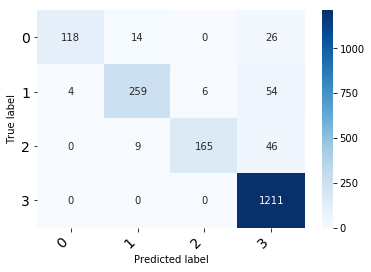

In [22]:
conf = pd.DataFrame(metrics.confusion_matrix(y_test, predicted_RFC))
heatmap = sns.heatmap(conf, annot=True, fmt='d', cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### ROC Curve

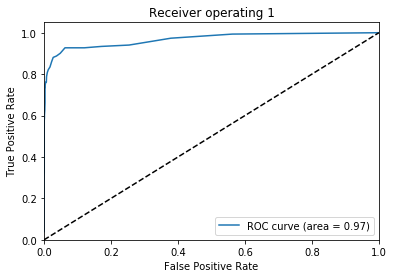

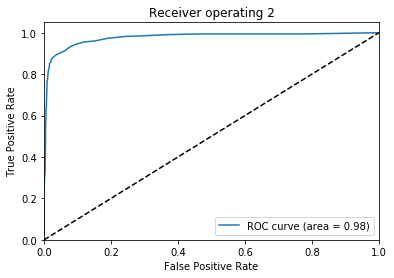

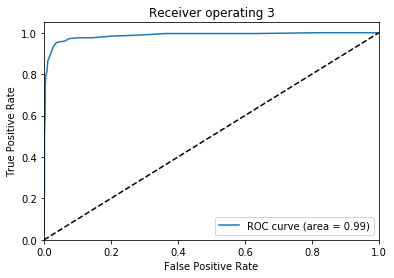

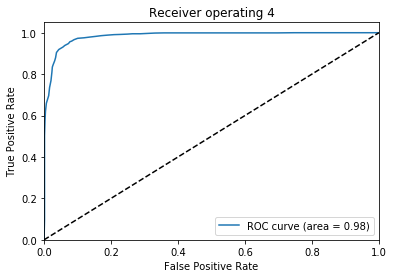

In [23]:
y = label_binarize(y, classes=[1,2,3,4])
n_classes = 4

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 50,random_state=0))
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating %d' %int(i+1))
    plt.legend(loc="lower right")
    plt.show()

### Features

In [24]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

X = pd.DataFrame(X)

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
0. feature meaneduc (0.053092)
1. feature SQBmeaned (0.042131)
2. feature overcrowding (0.025273)
3. feature SQBdependency (0.024728)
4. feature SQBhogar_nin (0.024702)
5. feature SQBovercrowding (0.024341)
6. feature escolari (0.022244)
7. feature qmobilephone (0.022043)
8. feature hogar_nin (0.020931)
9. feature r4t1 (0.020601)
10. feature dependency (0.020399)
11. feature rooms (0.019221)
12. feature SQBage (0.019033)
13. feature edjefe (0.018752)
14. feature SQBedjefe (0.018700)
15. feature age (0.018212)
16. feature eviv3 (0.017797)
17. feature agesq (0.017712)
18. feature r4m3 (0.015969)
19. feature v2a1 (0.015770)
20. feature r4h2 (0.015698)
21. feature r4h3 (0.015277)
22. feature tamviv (0.014314)
23. feature edjefa (0.013976)
24. feature SQBescolari (0.013853)
25. feature hogar_adul (0.013033)
26. feature v18q1 (0.012851)
27. feature r4t2 (0.012509)
28. feature cielorazo (0.012482)
29. feature bedrooms (0.012257)
30. feature paredblolad (0.012125)
31. feature 

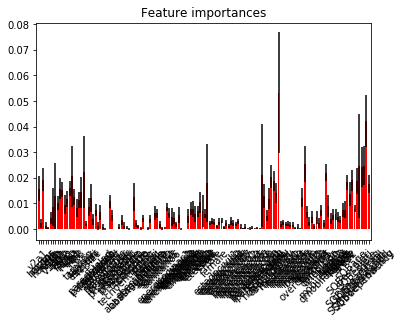

In [25]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances, color="r", yerr=std, align="center")
plt.xticks(range(X.shape[1]), X.columns, rotation = 45)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Top 20 Features

In [26]:
features = pd.DataFrame(X.columns,importances)
features.columns = ['Feat']
features.sort_index(ascending=False).head(20)

,Feat
0.053092,meaneduc
0.042131,SQBmeaned
0.025273,overcrowding
0.024728,SQBdependency
0.024702,SQBhogar_nin
0.024341,SQBovercrowding
0.022244,escolari
0.022043,qmobilephone
0.020931,hogar_nin
0.020601,r4t1


##### Only with SQB Values

In [27]:
X = data[[
    'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
    'SQBovercrowding', 'SQBdependency', 'SQBmeaned'
    ]]
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
clf_RFC_SQBV = RandomForestClassifier()
params = {'n_estimators': list(range(50,60,2))}
gs_RFC_SQBV = GridSearchCV(clf_RFC_SQBV, params, cv=5)
gs_RFC_SQBV.fit(X_train, y_train)
predicted = gs_RFC_SQBV.predict(X_test)

print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          1       0.62      0.54      0.57       147
          2       0.61      0.56      0.58       321
          3       0.69      0.46      0.55       226
          4       0.84      0.92      0.88      1218

avg / total       0.76      0.77      0.76      1912



### Feature engineering 

In [29]:
#Edjefx: Sum of Edjefe and Edjefa
#In all cases there is only one value for each
data['edjefe'] = data['edjefe'].astype(int)
data['edjefa'] = data['edjefa'].astype(int)
data['edjefx'] = data[['edjefe', 'edjefa']].sum(axis=1)
data.drop(['edjefe', 'edjefa'], axis = 1, inplace=True)

In [30]:
data['meanage'] = pd.Series(index=data.index)

mean_age = data[['Id','idhogar','age', 'meanage']]
me2 = mean_age.groupby('idhogar')['age'].mean().reset_index()

data['meanage'] = me2['age']
data['meanage'] = data['meanage'].fillna(0)

In [31]:
X = data[[
    'meaneduc','dependency', 'overcrowding', 'edjefx', 'qmobilephone',
     'hogar_nin', 'meanage', 'rooms', 'pisomoscer', 'cielorazo'
    ]]
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
clf_RFC_T12 = RandomForestClassifier()
params = {'n_estimators': list(range(50,60,2))}
gs_RFC_T12 = GridSearchCV(clf_RFC_T12, params, cv=5)
gs_RFC_T12.fit(X_train, y_train)
predicted = gs_RFC_T12.predict(X_test)

print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          1       0.97      0.81      0.88       166
          2       0.87      0.89      0.88       315
          3       0.89      0.88      0.88       220
          4       0.95      0.97      0.96      1211

avg / total       0.93      0.93      0.93      1912



###### Top 12 Heat Map

Text(0.5,15,'Predicted label')

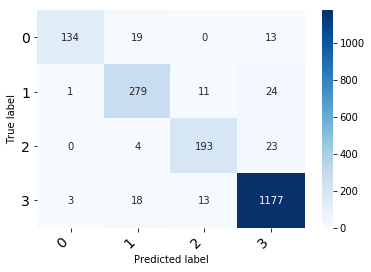

In [33]:
conf = pd.DataFrame(metrics.confusion_matrix(y_test, predicted))
heatmap = sns.heatmap(conf, annot=True, fmt='d', cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

##### Top 12 ROC Curve

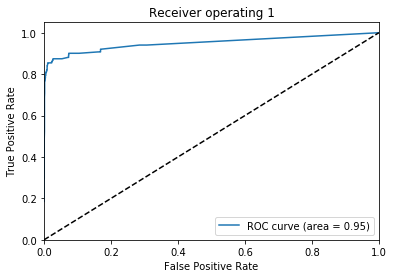

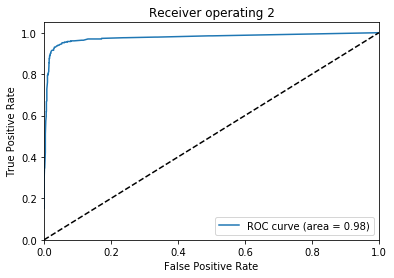

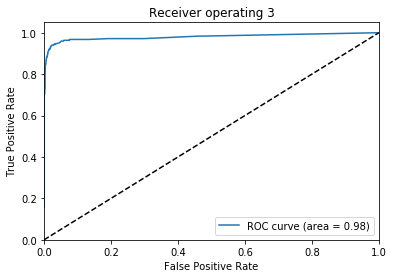

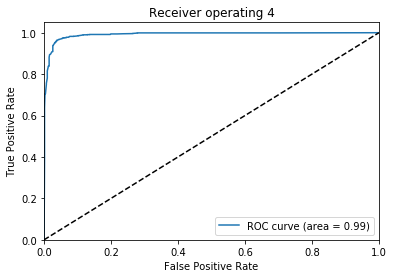

In [34]:
y = label_binarize(y, classes=[1,2,3,4])
n_classes = 4

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 50,random_state=0))
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating %d' %int(i+1))
    plt.legend(loc="lower right")
    plt.show()

# Conclusions

Through our analysis we came to the conclusion that the best classifier for this kind of data is the Random Forest Classifier. Furthermore, through our feature engineering we were able to achieve a better result than thatachieved from the original classifier, 10 features getting a better result than 143. 
Nevertheless, through our ROC curves and confusion matrix we are able to observe the more specific results of the classifier, we discovered most of the mistakes come from the first 3 levels, this is mainly due to the nature of the data which is loaded on the 4th level. 

# Further research

Further research is needed so as to achieve a better classification rate, those in need deserve this help and a better classification system would mean less people get left behind. Some of our suggestions are:

- More feature engineering, focused on reducing the number of features but without lowering the accuracy so as to combat the problem of colecting the data from poverty stricken homes
- Including more datasets with more data, such as the wheather this homes are exposed to, their location or others
- A more comprehensive analisis of how poverty works, accomanied by more social programs focused on not only giving income to these households but also preparing them through education so they can rise above their situation

# Sources:
Costa Rican Household Poverty Level Prediction. Kaggle. Visited on: 22/07/2018. Retrieved from: https://www.kaggle.com/c/costa-rican-household-poverty-prediction

Mejorando vidas. BID. Visited on: 23/07/2018. Retrieved from:  https://www.iadb.org/es

UNICEF (2011) Targeting the Poorest: An assessment of the proxy means test methodology.  Visited on: 23/07/2018. Retrieved from: https://www.unicef.org/socialpolicy/files/targeting-poorest.pdf